In [2]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

In [4]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [5]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

# Import constants

In [6]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

In [7]:
from rgc_natstim_model.constants.paths import base_directory
print(base_directory)

/mnt/lustre/work/bethge/bkr578/data/rgc-natstim


### define specific constants

In [8]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [9]:
marker_dict = {-4: "v",
               -2: "o",
               2: "s",
               4: "^"}
intensity_map = ScalarMappable(norm=Normalize(vmin=-2, vmax=2),
                               cmap="RdBu_r")

In [10]:
color_dict = {"-4":"k", "-2":"darkgreen", "2":"darkviolet", "4":"red"}

# Load data from file

In [11]:
with open(os.path.join(base_directory, 'data', 'base', 'restr_data_df.pkl'), 'rb') as f:
    df = pickle.load(f)

# Assemble paths

In [16]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-07-20_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-07-20_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

model_type = 'nonlinear'

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

### movies

In [17]:
# load the movie 
movies_dict = pickle.load(open('/'.join([base_directory, 'data', 'movie', movie_file_name]), "rb"))

# load the movie file with the pre-flip-correction movie
movies_dict_flip = pickle.load(open('/'.join([base_directory, 'data', 'movie', flipped_movie_file_name]), "rb"))

In [18]:
train_movie_snippets = movies_dict['train'].reshape(2, 108, 150, 18, 16, order="C")
test_movie_snippets = movies_dict['test'].reshape(2, 5, 150, 18, 16, order="C")

### load all datasets

In [19]:
movie_data_dicts = {}
for dh, dfn in zip(dataset_hashes, data_file_names):
    data_path = os.path.join(base_directory, "data", 'base', dfn)
    responses = load_h5_into_dict(data_path)
    _movie_data_dict = make_final_responses(responses, response_type="natural") # upsampling
    movie_data_dicts.update({dh:_movie_data_dict})

Loading HDF5 file contents: 100%|██████████| 385/385 [00:01<00:00, 231.06item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 11/11 [00:00<00:00, 29.57it/s]
Loading HDF5 file contents: 100%|██████████| 175/175 [00:00<00:00, 259.80item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 5/5 [00:00<00:00, 39.10it/s]
Loading HDF5 file contents: 100%|██████████| 140/140 [00:00<00:00, 280.28item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 4/4 [00:00<00:00, 33.52it/s]
Loading HDF5 file contents: 100%|██████████| 700/700 [00:03<00:00, 221.43item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 20/20 [00:00<00:00, 26.56it/s]
Loading HDF5 file contents: 100%|██████████| 210/210 [00:00<00:00, 281.66item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 6/6 [00:00<00:00, 38.94it/s]
Loading HDF5 file contents: 100%|██████████| 945/945 [00:04<00:00, 207.93item/s]
Upsampling natural traces

In [20]:
# ToDo 
dh_2_session_ids = {k: list(v.keys()) for k, v in movie_data_dicts.items()}
session_ids_2_dhs = {_v: k for k, v in movie_data_dicts.items() for _v in list(v.keys())}
# remove empty session
session_ids_2_dhs.pop('session_1_ventral2_20200701')
dh_2_session_ids['5e620609fc7b491aa5edb4a5d4cd7276'].remove('session_1_ventral2_20200701')

dh_2_session_ids_renamed = {dh: ['_'.join(el.split('_')[1:]) for el in v] for dh, v in dh_2_session_ids.items()}

# get binned responses

In [21]:
from rgc_natstim_model.analyses.context_change_detection import get_resp_dicts, SessionMappings, get_movie_contrast_by_session

In [22]:
full_movie_resp_dict, binned_movie_resp_dict = get_resp_dicts(
    df
)

# Get session mapping

In [23]:
import rgc_natstim_model.constants.context_change_detection as CONSTANTS

In [24]:
session_mappings = SessionMappings(train_movie_snippets, test_movie_snippets, CONSTANTS.RANDOM_SEQUENCES_PATH,
                                                    CONSTANTS.GROUP_INFO_PATH, CONSTANTS.DUR_MOVIE)

In [25]:
session_mappings.get_session_mappings(movie_data_dicts, dh_2_session_ids)

In [26]:
all_session_ids = list(session_mappings.sess2vertical_transitions_dict.keys())

# get movie contrasts for sessions

#### full field

In [27]:
movie_contrast_session_ff = get_movie_contrast_by_session(
    all_session_ids, session_mappings.sess2movie_dict
)

# ROC

In [28]:
from rgc_natstim_model.analyses.context_change_detection import get_roc_curve, get_ind_roc_curve

### ground to sky

In [29]:
tpr_by_type = {}
fpr_by_type = {}
auc_by_type = {}
tpr_by_nid= {}
fpr_by_nid= {}
auc_by_nid= {}
f_by_nid= {}
f_inv_by_nid = {}
thresholds_by_nid = {}
for t in range(1, 33):
    tpr_by_nid_temp, fpr_by_nid_temp, auc_by_nid_temp, f_by_nid_temp, f_inv_by_nid_temp, thresholds_by_nid_temp = get_ind_roc_curve(
        df, 
        session_mappings.sess2vertical_transitions_dict, 
        binned_movie_resp_dict, 
        cell_type=t, 
        target_transition = 4,
        above_threshold=True,
        offtarget_transition="all"
    )
    tpr_by_nid.update(tpr_by_nid_temp)
    fpr_by_nid.update(fpr_by_nid_temp)
    auc_by_nid.update(auc_by_nid_temp)
    f_by_nid.update(f_by_nid_temp)
    f_inv_by_nid.update(f_inv_by_nid_temp)
    thresholds_by_nid.update(thresholds_by_nid_temp)
    tpr_by_type[t] = np.asarray([tpr_by_nid_temp[nid] for nid in tpr_by_nid_temp.keys()])
    fpr_by_type[t] = np.asarray([fpr_by_nid_temp[nid] for nid in fpr_by_nid_temp.keys()])
    auc_by_type[t] = np.asarray([auc_by_nid_temp[nid] for nid in auc_by_nid_temp.keys()])

# Perform statistical analyses

In [30]:
from scipy.stats import ttest_ind

In [32]:
from tabulate import tabulate

In [33]:
alpha = 0.05
n_comparisons = 31
bonferroni = alpha/n_comparisons
print(bonferroni)

0.0016129032258064516


In [34]:
n_t = 2
n_n = 3
table_data = []

for t in range(1, 33):
    if len(auc_by_type[t]) > 2:
        curr_auc = auc_by_type[t].mean()
        stats, p = ttest_ind(auc_by_type[28], auc_by_type[t])
        n = len(auc_by_type[t])
        table_data.append([
            f'{t:0{n_t}d}',
            f'{n:0{n_n}d}',
            f'{curr_auc:03.3f}',
            f'{stats:05.2f}',
            f'{p:06.5f}'
        ])

# Define the headers
headers = ["Type", "n", "AUC", "t-test stat", "p-value"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+--------+-----+-------+---------------+-----------+
|   Type |   n |   AUC |   t-test stat |   p-value |
+========+=====+=======+===============+===========+
|     01 | 086 | 0.515 |         13.25 |   0       |
+--------+-----+-------+---------------+-----------+
|     02 | 035 | 0.51  |         10.44 |   0       |
+--------+-----+-------+---------------+-----------+
|     03 | 022 | 0.482 |         10.24 |   0       |
+--------+-----+-------+---------------+-----------+
|     04 | 094 | 0.475 |         18.03 |   0       |
+--------+-----+-------+---------------+-----------+
|     05 | 033 | 0.391 |         18.78 |   0       |
+--------+-----+-------+---------------+-----------+
|     06 | 023 | 0.482 |         10.17 |   0       |
+--------+-----+-------+---------------+-----------+
|     07 | 047 | 0.508 |         11.66 |   0       |
+--------+-----+-------+---------------+-----------+
|     08 | 016 | 0.453 |         10.06 |   0       |
+--------+-----+-------+---------------+------

In [35]:
auc_all_others = np.concatenate([auc_by_type[t] for t in range(1,33) if not(t==28)])
print("n = {}, mean AUC: {:.2f}, std: {:.2f}".format(
        len(auc_all_others), auc_all_others.mean(), np.std(auc_all_others)))

n = 3449, mean AUC: 0.52, std: 0.09


In [36]:
stats, p = ttest_ind(auc_by_type[28], auc_by_type[24])
print(stats, p)

3.571537932324766 0.0005371807367092352


In [37]:
stats, p = ttest_ind(auc_by_type[28], np.concatenate([auc_by_type[t] for t in range(1,33) if not(t==28)]), alternative="greater")
print(stats, p)

15.884892880393902 3.1099718402492162e-55


### calculate effect size

In [38]:
from rgc_natstim_model.analyses.context_change_detection import cohens_d, bootstrap_ci, perform_permutation_test

In [39]:
np.round(cohens_d(auc_by_type[24], auc_by_type[28]), 2)

0.78

### bootstrap confidence interval

In [40]:
diff_auc = auc_by_type[28].mean() - auc_by_type[24].mean()
print(diff_auc)

0.06468635226884589


In [41]:
ci, dist = bootstrap_ci(auc_by_type[28], auc_by_type[24])
print([np.round(bound, 4) for bound in ci])

[0.0274, 0.1085]


In [42]:
ci_all, dist = bootstrap_ci(auc_by_type[28], auc_all_others)
print([np.round(bound, 4) for bound in ci_all])

[0.1412, 0.1778]


### permutation test

In [43]:
diffs, orig_diff, p = perform_permutation_test(auc_by_type[24], auc_by_type[28], n_rep=100000)
print(p, diffs.mean(), orig_diff)

0.00069 0.015175728459917097 0.06468635226884589


# plot ROC results

In [44]:
from rgc_natstim_model.plotting.context_change_detection import kde_for_display

In [45]:
from rgc_natstim_model.constants.plot_settings import cmap_colors

In [46]:
from matplotlib.ticker import FixedLocator

In [47]:
rc_dict_boxplot = {'figure.dpi': 300,
 'figure.figsize': [5, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.markersize': 0.5,
 'lines.linewidth': .5,
 'lines.markeredgewidth': 0.5,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

In [48]:
bins = np.linspace(.2, .8, 20)
auc_dist_by_type = {}
for t in range(1, 33):
    x_locs, auc_dist_by_type[t] = kde_for_display(auc_by_type[t], bins=bins, 
                                                  n_samples=50, norm=False)

In [49]:
x_locs, dist_all = kde_for_display(np.concatenate([auc_by_type[t] for t in range(1, 33)]),
                                   bins=bins, n_samples=50, norm=True
                                  )

In [50]:
auc_all = np.concatenate([auc_by_type[t] for t in range(1, 33)])

/tmp/ipykernel_1616/722798961.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)


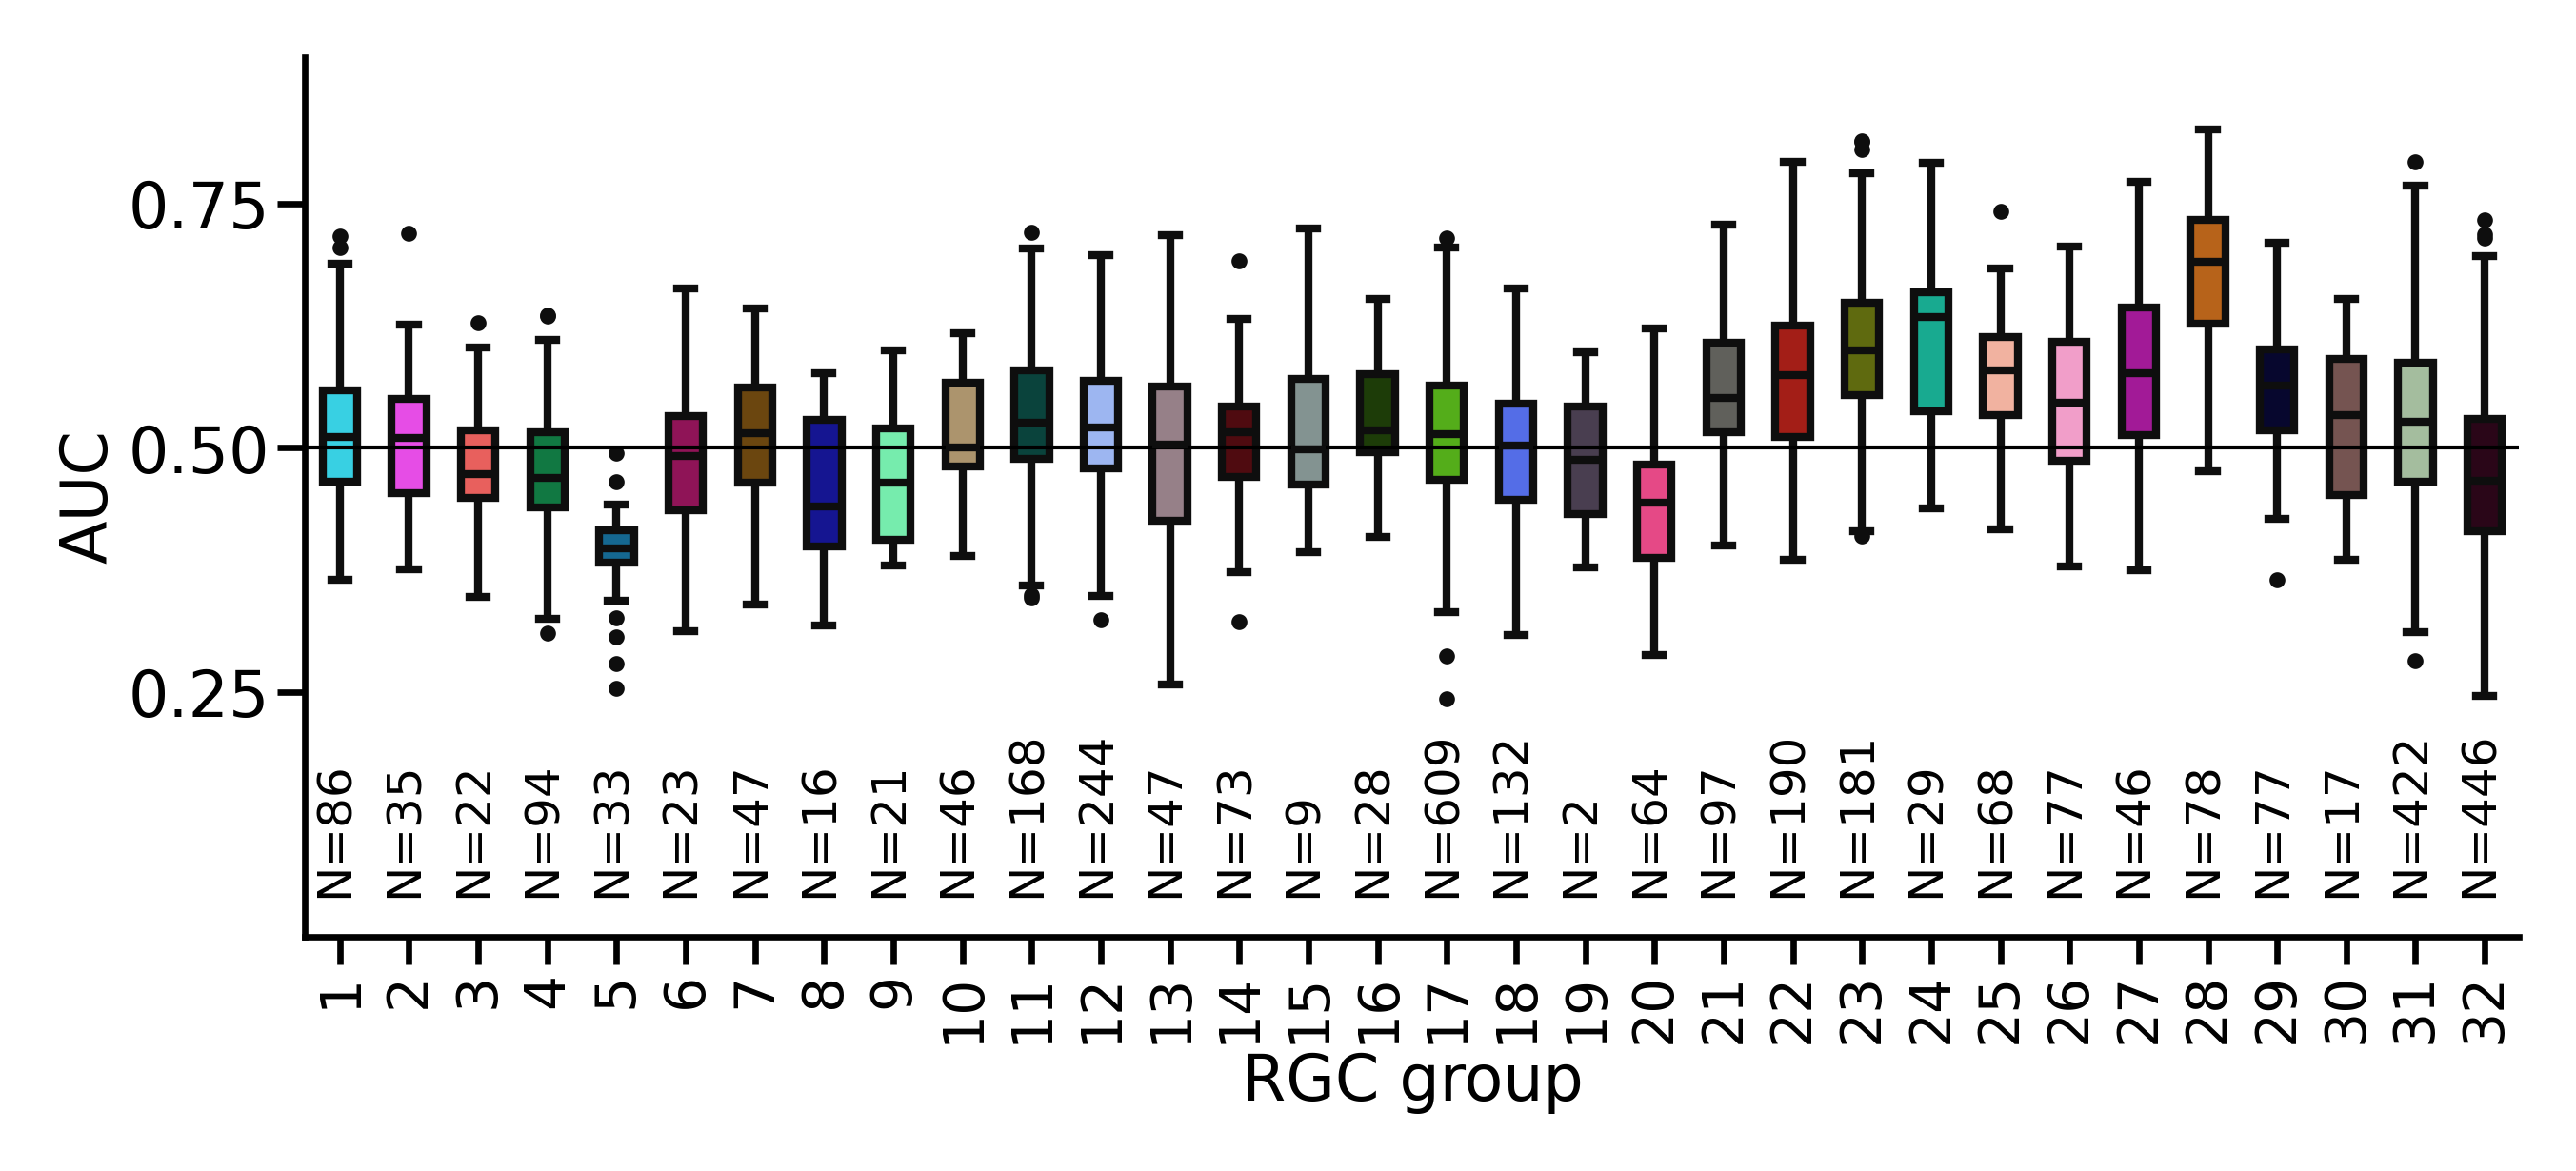

In [51]:
with mpl.rc_context(rc_dict_boxplot):
    sns.boxplot(data=[auc_by_type[t] for t in range(1, 33)], orient="v",
               palette=[cmap_colors[t-1] for t in range(1, 33)], fliersize=1, width=.5);
    plt.gca().yaxis.set_major_locator(FixedLocator([0.25, 0.5, 0.75]))
    plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)
    #plt.gca().set_xticklabels(["N = {:d}".format(len(auc_by_type[t])) for t in range(1, 33)], rotation=90)
    for t in range(1, 33):
        plt.annotate("N={}".format(len(auc_by_type[t])), xy=[t-1.4, 0.05], rotation="vertical", fontsize=6)
    sns.despine()
    plt.gca().axhline(0.5, color="k")
    plt.xlabel("RGC group")
    plt.ylabel("AUC")
    plt.ylim(0, 0.9)
    #save_this(r'/gpfs01/euler/User/lhoefling/Plots/paper_figs/fig_contrast/suppl/', fname='boxplot_auc')